In [60]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from utility import (
    load_object
)
import yfinance as yf


In [107]:
fileName = 'results/surrogate_model_15_40_28_26_04_2024'

In [62]:
# Defne a NN model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        super(Net, self).__init__()
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        # Define bounds for the output
        lower_bounds = torch.tensor([0.01, -10.0, 0.01, 0.01, 0.01, 0.01, 0.01])
        upper_bounds = torch.tensor([10.0, 10.0, 10.0, 10.0, 0.45, 0.45, 0.99])
        # Apply the bounds
        x = torch.sigmoid(self.fc4(x))
        x = lower_bounds + x * (upper_bounds - lower_bounds)
        return x

In [108]:
parameters_list = load_object(fileName + "/Data", "param_values")
returns_timeseries_arr = load_object(fileName + "/Data", "returns_timeseries_arr")

input_size = returns_timeseries_arr.shape[2]
hidden_size = 50
output_size = parameters_list.shape[1]


In [116]:
#Prepare the data for the neural network
X = torch.tensor(np.asarray(returns_timeseries_arr[0])).float()
y = torch.tensor(parameters_list).float()

In [117]:
#Initialize empty parameter list
parameters = []
# import the surrogate models
for i, _ in enumerate(returns_timeseries_arr):
    model = Net(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(fileName + '/Data/model_' + str(i)))

    # Predict the parameters on X[0]
    y_pred = model(X[9])
    parameters.append(y_pred)


In [118]:
# Compute the average of the parameters and the min and max
parameters = torch.stack(parameters)
parameters_mean = torch.mean(parameters, dim=0)
parameters_min = torch.min(parameters, dim=0)[0]
parameters_max = torch.max(parameters, dim=0)[0]

print("Mean parameters: ", parameters_mean)
print("Min parameters: ", parameters_min)
print("Max parameters: ", parameters_max)

#print the actual parameters
print("Actual parameters: ", y[9])

Mean parameters:  tensor([ 2.6952, -7.2622,  5.5757,  5.4033,  0.1519,  0.1165,  0.6155],
       grad_fn=<MeanBackward1>)
Min parameters:  tensor([ 0.3854, -9.9559,  0.1774,  0.3515,  0.0685,  0.0510,  0.2228],
       grad_fn=<MinBackward0>)
Max parameters:  tensor([4.9866, 4.4839, 9.2956, 9.9861, 0.2307, 0.2003, 0.8262],
       grad_fn=<MaxBackward0>)
Actual parameters:  tensor([5.0343, 5.0195, 4.5465, 4.9172, 0.4315, 0.0388, 0.1220])


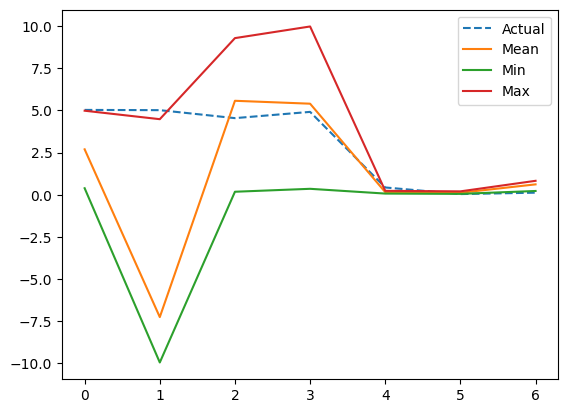

In [119]:
#plot the actual parameters and min and max as candlesticks
fig, ax = plt.subplots()
ax.plot(y[9].detach().numpy(), label='Actual', linestyle='--')
ax.plot(parameters_mean.detach().numpy() , label='Mean')
ax.plot(parameters_min.detach().numpy() , label='Min')
ax.plot(parameters_max.detach().numpy() , label='Max')
ax.legend()
plt.show()

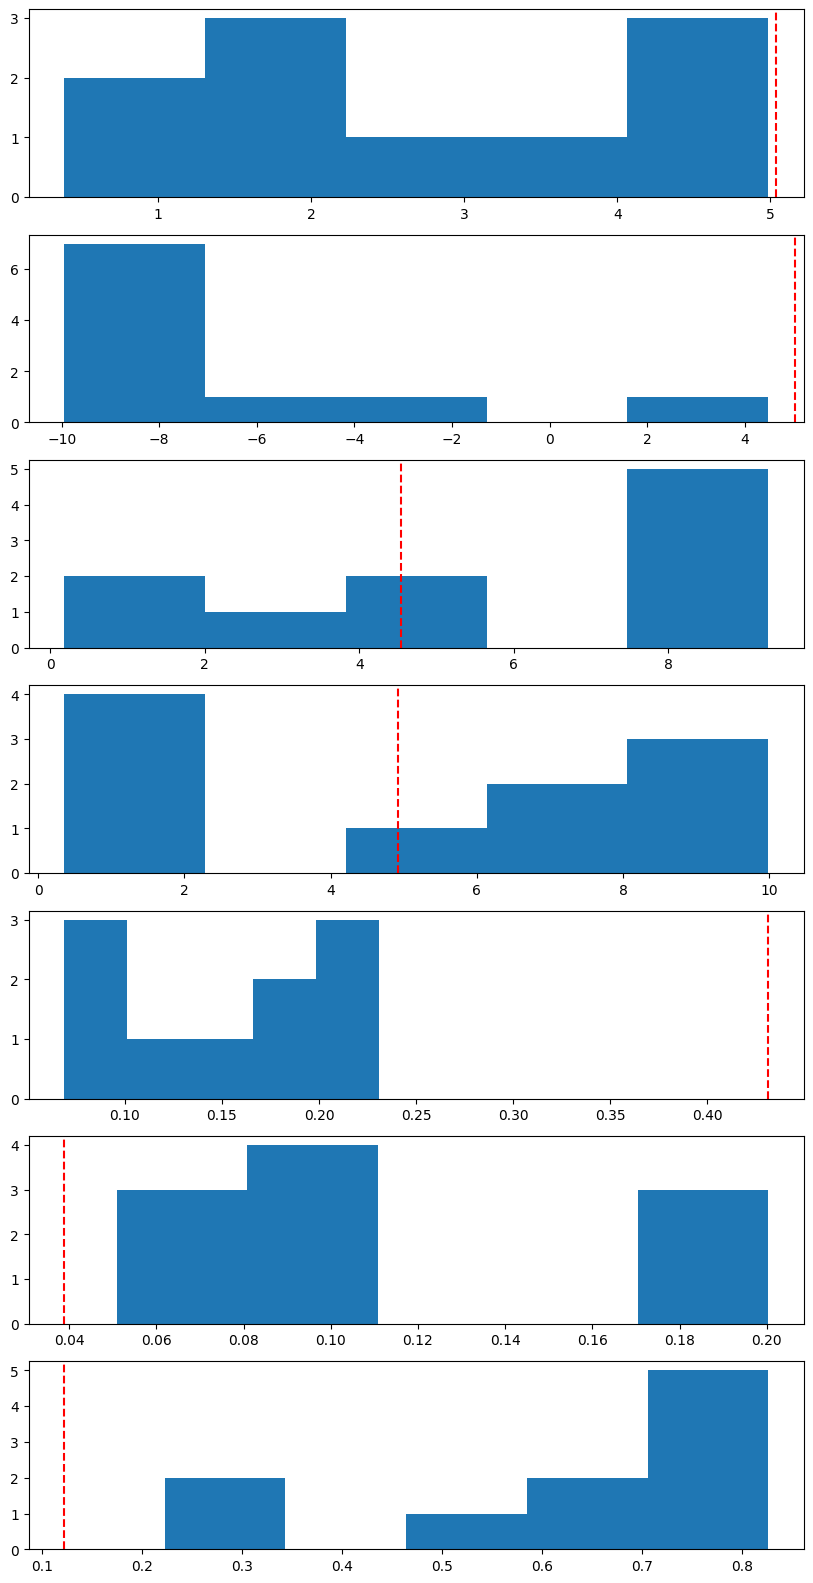

In [120]:
#plot seven subplots with the histograms of the parameters distribution for each parameter
fig, axs = plt.subplots(7, figsize=(10, 20))
for i in range(7):
    axs[i].hist(parameters[:, i].detach().numpy(), bins=5)
    #add the actual parameter value as a vertical line
    axs[i].axvline(y[9][i].detach().numpy(), color='r', linestyle='--')

In [65]:
#import the NN model from the Data file in pt format
model = Net(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(fileName + "/Data/NN_model.pt"))

<All keys matched successfully>

In [66]:
#evaluate the model on X[0]
model(X[0]), y[0]

(tensor([ 0.1528, -0.5877,  1.5260,  1.5502,  0.1509,  0.2003,  0.7342],
        grad_fn=<AddBackward0>),
 tensor([ 0.1014, -0.3726,  1.4948,  1.5190,  0.0867,  0.1865,  0.8375]))

In [69]:
# Now we get real data
# get Apple stock data on daily basis
aapl = yf.Ticker("TSLA")
aapl_hist = aapl.history(period="2y")
aapl_hist = aapl_hist.dropna()

#add a column daily return
aapl_hist['daily_return'] = aapl_hist['Close'].pct_change()

x_real = aapl_hist['daily_return'].values[-input_size:]
#convert to tensor
X_real = torch.tensor(x_real).float().view(1,-1)

#predict the parameters
y_pred = model(X_real)


In [70]:
y_pred

tensor([[0.7823, 0.2824, 0.4878, 0.0937, 0.0498, 0.0991, 0.2882]],
       grad_fn=<AddBackward0>)